**классификатор LSTM c Embedding**

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
# печатать выход каждой строки ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
from torchviz import make_dot

## данные

In [4]:
n_samples = 100 # количество примеров

seq_len = 3 # длина последовательности
emb_dim = 8 # размер представления для элемента последовательности

max_val = 9 # количество элементов, из которых будем формировать последовательности

hid_dim = 32 # размер реккурентного слоя
output_dim = 2 # размер выхода

In [5]:
x = torch.randint(high=max_val+1, size=(n_samples,seq_len) ) # генерируем случайные последовательности
y = torch.randint( high=output_dim, size=(n_samples,) ) # случайные метки примеров 
# y = torch.nn.functional.one_hot(y).to(torch.float32) # преобразуем номер класса в OHE вектор {0,1}

In [6]:
x.shape, x[:5,:] # входы, последовательности целых чисел (номеров)
y.shape, y[:5] # выходы, номера классов

(torch.Size([100, 3]),
 tensor([[7, 3, 6],
         [9, 2, 2],
         [4, 4, 3],
         [8, 0, 2],
         [1, 8, 9]]))

(torch.Size([100]), tensor([1, 0, 0, 0, 1]))

## Embedding

In [7]:
# последовательность из номеров
x[:1,:]

tensor([[7, 3, 6]])

In [8]:
# унитарное кодирование (OHE) номеров
torch.nn.functional.one_hot( x[:1,:] )

tensor([[[0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]]])

In [9]:
# линейный слой без сдвигов (bias) с унитарным кодированием (OHE)
# вначале преобразует номер в OHE 
# затем OHE умножаем на матрицу весов Embedding слоя
emb = nn.Embedding(
    num_embeddings=max_val+1, # размер входа (длина OHE)
    embedding_dim=emb_dim # размер выхода
)

In [10]:
out = emb(x[:1,:])
x[:1,:].shape # размер входа, последовательность целых чисел
out.shape # размер выхода, последовательность векторов embedding
out

torch.Size([1, 3])

torch.Size([1, 3, 8])

tensor([[[ 0.4038,  0.7904, -0.3673,  0.6690,  0.7414, -0.0455, -0.7278,
           0.7008],
         [-0.2367, -0.3499,  1.4043, -0.3720,  1.4815, -0.6278,  1.0190,
           0.9196],
         [ 0.0522,  1.7203, -1.4838, -0.6181, -0.4549, -0.2035, -1.4754,
          -0.1092]]], grad_fn=<EmbeddingBackward>)

## строим модель

In [11]:
class Model(nn.Module):
    def __init__(self, num_embeddings=max_val+1, hid_dim=hid_dim, output_dim=2):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, emb_dim) 
        self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True) # рекуррентный слой
        self.linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой
        
    def forward(self,x):
        out = self.emb(x)
        _, (hidden, _) = self.rnn(out) # обрабатываем входную последовательность
        hidden = hidden.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        out = self.linear(hidden) # считаем выход сети
        return out 

In [12]:
model = Model()
model

Model(
  (emb): Embedding(10, 8)
  (rnn): LSTM(8, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=2, bias=True)
)

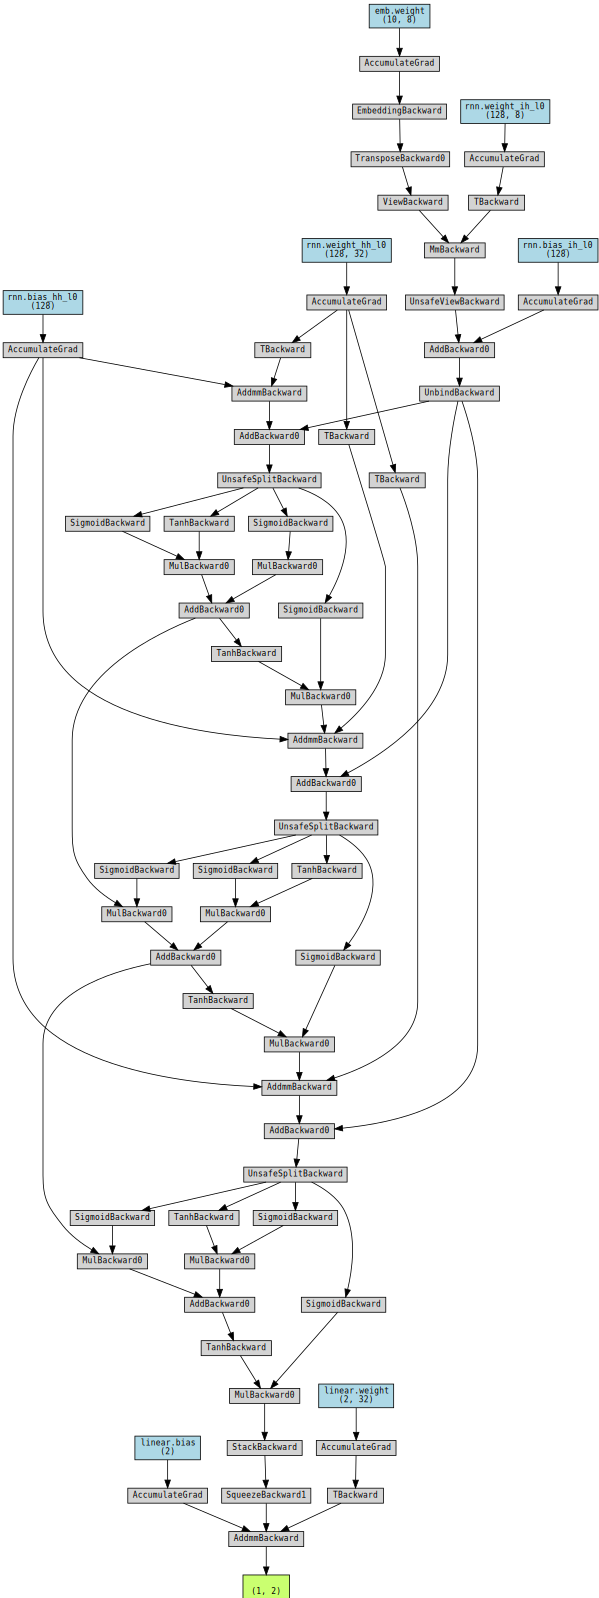

In [13]:
z = torch.zeros( size=(1,seq_len), dtype=torch.int, requires_grad=False)
out = model(z)
make_dot( out, params=dict(list(model.named_parameters())), ) #show_attrs=True )  
# .render("rnn_torchviz", format="png")

In [14]:
# import hiddenlayer as hl
# hl.build_graph(model, 
#                z, 
#                transforms=[ 
#                    hl.transforms.Prune('Constant'), 
#                    hl.transforms.Prune('Unsqueeze'), 
#                    hl.transforms.Prune('Squeeze'), 
#                    hl.transforms.Prune('Slice'), 
#                    hl.transforms.Prune('Concat'), 
#                ])


## обучаем модель

In [15]:
loss_function =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
epochs = 151
hist = []
for i in range(epochs):
    optimizer.zero_grad() # обнуляем значения градиента
    out = model(x) # вычисляем выход, прямой проход
    loss = loss_function(out,y) # вычисляем значение потери
    loss.backward() # вычисляем значения градиента потери, обратный проход
    optimizer.step() # изменяем значения весов модели
    if((i%50)==1): print(f'epoch: {i:3} loss: {loss.item():10.8f}')
    hist.append( loss.item() ) # сохраняем текущее значение потери

# print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.67944688
epoch:  51 loss: 0.05974760
epoch: 101 loss: 0.05589648


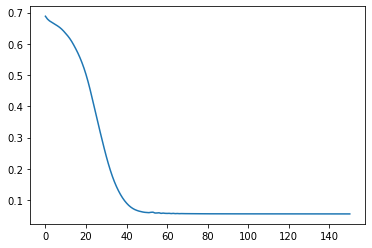

In [17]:
# изменение значения потери в процессе обучения
plt.plot(hist)